# Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Obtain Data

In [3]:
df = pd.read_csv('Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Scrub Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Drop columns not useful for modeling

In [5]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Create dummy columns for Pclass and categorical variables

In [6]:
df = pd.get_dummies(df, columns=['Pclass', 'Sex'], drop_first='True')
df.head()

,Survived,Age,SibSp,Parch,Fare,Embarked,Pclass_2,Pclass_3,Sex_male
0,0,22.0,1,0,7.2500,S,0,1,1
1,1,38.0,1,0,71.2833,C,0,0,0
2,1,26.0,0,0,7.9250,S,0,1,0
3,1,35.0,1,0,53.1000,S,0,0,0
4,0,35.0,0,0,8.0500,S,0,1,1


Create dummy columns for Embarked variable, while mantaining Embarked np.nan values in the dummy columns

In [7]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first='True', dummy_na=True)

def embarked_na(row):
    if row['Embarked_nan'] == 1:
        row['Embarked_Q'] = np.nan
        row['Embarked_S'] = np.nan
        return row
    else:
        return row

df = df.apply(embarked_na, axis=1)
df.drop(columns='Embarked_nan', inplace=True)
df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0.0,22.0,1.0,0.0,7.2500,0.0,1.0,1.0,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,0.0,0.0
2,1.0,26.0,0.0,0.0,7.9250,0.0,1.0,0.0,0.0,1.0
3,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,0.0,1.0
4,0.0,35.0,0.0,0.0,8.0500,0.0,1.0,1.0,0.0,1.0


Merge SibSp values >= 5 into a single class and create dummy variables for SibSp

In [8]:
scrub_x = df.drop(columns='Survived')
scrub_y = df['Survived']

scrub_xtrain, scrub_xtest, scrub_ytrain, scrub_ytest = train_test_split(scrub_x, scrub_y, 
                                                                            test_size=0.25, random_state=121)

scrub_df = pd.concat([scrub_xtrain, scrub_ytrain], axis=1)

print('Survival Rates # by SibSp')
print(scrub_df.groupby('SibSp').mean()[['Survived']])
print('SibSp Value Counts')
print(scrub_df['SibSp'].value_counts())

df['SibSp'] = df['SibSp'].apply(lambda x: min(x, 5))
df = pd.get_dummies(df, columns=['SibSp'], drop_first=True)
df.head()

Survival Rates # by SibSp
       Survived
SibSp          
0.0    0.334773
1.0    0.546667
2.0    0.450000
3.0    0.363636
4.0    0.214286
5.0    0.000000
8.0    0.000000
SibSp Value Counts
0.0    463
1.0    150
2.0     20
4.0     14
3.0     11
8.0      6
5.0      4
Name: SibSp, dtype: int64


,Survived,Age,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0
0,0.0,22.0,0.0,7.2500,0.0,1.0,1.0,0.0,1.0,1,0,0,0,0
1,1.0,38.0,0.0,71.2833,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2,1.0,26.0,0.0,7.9250,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0
3,1.0,35.0,0.0,53.1000,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0
4,0.0,35.0,0.0,8.0500,0.0,1.0,1.0,0.0,1.0,0,0,0,0,0


Merge Parch values >= 3 into a single class and create dummy variables for Parch

In [9]:
print('Survival Rates # by Parch')
print(scrub_df.groupby('Parch').mean()[['Survived']])
print('Parch Value Counts')
print(scrub_df['Parch'].value_counts())

df['Parch'] = df['Parch'].apply(lambda x: min(x, 3))
df = pd.get_dummies(df, columns=['Parch'], drop_first=True)
df.head()

Survival Rates # by Parch
       Survived
Parch          
0.0    0.335283
1.0    0.542169
2.0    0.516129
3.0    1.000000
4.0    0.000000
5.0    0.250000
6.0    0.000000
Parch Value Counts
0.0    513
1.0     83
2.0     62
5.0      4
3.0      3
4.0      2
6.0      1
Name: Parch, dtype: int64


,Survived,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,Parch_1.0,Parch_2.0,Parch_3.0
0,0.0,22.0,7.2500,0.0,1.0,1.0,0.0,1.0,1,0,0,0,0,0,0,0
1,1.0,38.0,71.2833,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0
2,1.0,26.0,7.9250,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0
3,1.0,35.0,53.1000,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0
4,0.0,35.0,8.0500,0.0,1.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0


Impute missing values with knn imputer

In [10]:
impute_x = df.drop(columns=['Survived'])
impute_y = df['Survived']

impute_xtrain, impute_xtest, impute_ytrain, impute_ytest = train_test_split(impute_x, impute_y, 
                                                                            test_size=0.25, random_state=121)

impute_ss = StandardScaler()
impute_ss.fit(impute_xtrain)
impute_xtrain = pd.DataFrame(impute_ss.transform(impute_xtrain), columns=impute_xtrain.columns, 
                             index=impute_xtrain.index)
impute_x = pd.DataFrame(impute_ss.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

imputer = KNNImputer()
imputer.fit(impute_xtrain)
impute_x = pd.DataFrame(imputer.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

impute_x = pd.DataFrame(impute_ss.inverse_transform(impute_x), columns=impute_x.columns, index=impute_x.index)
df = pd.concat([impute_x, impute_y], axis=1)
df = df.round(4)
df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,Parch_1.0,Parch_2.0,Parch_3.0,Survived
0,22.0,7.2500,-0.0,1.0,1.0,0.0,1.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
1,38.0,71.2833,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0
2,26.0,7.9250,-0.0,1.0,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0
3,35.0,53.1000,-0.0,0.0,0.0,0.0,1.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0
4,35.0,8.0500,-0.0,1.0,1.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0


Confirm data now scrubbed with df.info()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Fare        891 non-null    float64
 2   Pclass_2    891 non-null    float64
 3   Pclass_3    891 non-null    float64
 4   Sex_male    891 non-null    float64
 5   Embarked_Q  891 non-null    float64
 6   Embarked_S  891 non-null    float64
 7   SibSp_1.0   891 non-null    float64
 8   SibSp_2.0   891 non-null    float64
 9   SibSp_3.0   891 non-null    float64
 10  SibSp_4.0   891 non-null    float64
 11  SibSp_5.0   891 non-null    float64
 12  Parch_1.0   891 non-null    float64
 13  Parch_2.0   891 non-null    float64
 14  Parch_3.0   891 non-null    float64
 15  Survived    891 non-null    float64
dtypes: float64(16)
memory usage: 111.5 KB


# Explore Data

Find train set outliers with isolation forest

In [12]:
isf_x = df.drop(columns='Survived')
isf_y = df['Survived']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y, test_size=0.25, random_state=121)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.02)
isf_xtrain['Outlier'] = isf.fit_predict(isf_xtrain)
isf_xtrain[isf_xtrain['Outlier']==-1].round(1)

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,Parch_1.0,Parch_2.0,Parch_3.0,Outlier
278,-1.7,0.0,-0.5,0.9,0.7,3.2,-1.6,-0.5,-0.2,-0.1,6.8,-0.1,2.7,-0.3,-0.1,-1
245,1.0,1.5,-0.5,-1.1,0.7,3.2,-1.6,-0.5,5.7,-0.1,-0.1,-0.1,-0.4,-0.3,-0.1,-1
311,-0.9,5.7,-0.5,-1.1,-1.4,-0.3,-1.6,-0.5,5.7,-0.1,-0.1,-0.1,-0.4,3.1,-0.1,-1
183,-2.1,0.2,2.0,-1.1,0.7,-0.3,0.6,-0.5,5.7,-0.1,-0.1,-0.1,2.7,-0.3,-0.1,-1
644,-2.1,-0.2,-0.5,0.9,-1.4,-0.3,-1.6,-0.5,5.7,-0.1,-0.1,-0.1,2.7,-0.3,-0.1,-1
787,-1.6,0.0,-0.5,0.9,0.7,3.2,-1.6,-0.5,-0.2,-0.1,6.8,-0.1,2.7,-0.3,-0.1,-1
171,-1.9,0.0,-0.5,0.9,0.7,3.2,-1.6,-0.5,-0.2,-0.1,6.8,-0.1,2.7,-0.3,-0.1,-1
437,-0.4,-0.3,2.0,-1.1,-1.4,-0.3,0.6,-0.5,5.7,-0.1,-0.1,-0.1,-0.4,-0.3,8.1,-1
600,-0.4,-0.0,2.0,-1.1,-1.4,-0.3,0.6,-0.5,5.7,-0.1,-0.1,-0.1,2.7,-0.3,-0.1,-1
341,-0.4,5.7,-0.5,-1.1,-1.4,-0.3,0.6,-0.5,-0.2,7.7,-0.1,-0.1,-0.4,3.1,-0.1,-1


Find test set outliers with Isolation Forest

In [13]:
isf_xtest = pd.DataFrame(isf_ss.transform(isf_xtest), columns=isf_xtest.columns, index=isf_xtest.index)
isf_xtest['Outlier'] = isf.predict(isf_xtest)
isf_xtest[isf_xtest['Outlier']==-1].round(1)

,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,Parch_1.0,Parch_2.0,Parch_3.0,Outlier
43,-1.9,0.3,2.0,-1.1,-1.4,-0.3,-1.6,1.9,-0.2,-0.1,-0.1,-0.1,-0.4,3.1,-0.1,-1
16,-2.0,0.0,-0.5,0.9,0.7,3.2,-1.6,-0.5,-0.2,-0.1,6.8,-0.1,2.7,-0.3,-0.1,-1
679,0.4,11.8,-0.5,-1.1,0.7,-0.3,-1.6,-0.5,-0.2,-0.1,-0.1,-0.1,2.7,-0.3,-0.1,-1
742,-0.7,5.7,-0.5,-1.1,-1.4,-0.3,-1.6,-0.5,5.7,-0.1,-0.1,-0.1,-0.4,3.1,-0.1,-1
657,0.1,-0.3,-0.5,0.9,-1.4,3.2,-1.6,1.9,-0.2,-0.1,-0.1,-0.1,2.7,-0.3,-0.1,-1
438,2.4,5.7,-0.5,-1.1,0.7,-0.3,0.6,1.9,-0.2,-0.1,-0.1,-0.1,-0.4,-0.3,8.1,-1
27,-0.8,5.7,-0.5,-1.1,0.7,-0.3,0.6,-0.5,-0.2,7.7,-0.1,-0.1,-0.4,3.1,-0.1,-1


Replace all Age and Fare values > 4 standard deviations from the mean with the 4 standard deviation value

In [14]:
replace_x = df.drop(columns='Survived')
replace_y = df['Survived']

replace_xtrain, replace_xtest, replace_ytrain, replace_ytest = train_test_split(replace_x, replace_y, 
                                                                            test_size=0.25, random_state=121)

replace_ss = StandardScaler()
replace_ss.fit(replace_xtrain)
replace_xtrain = pd.DataFrame(replace_ss.transform(replace_xtrain), columns=replace_xtrain.columns, 
                             index=replace_xtrain.index)
replace_x = pd.DataFrame(replace_ss.transform(replace_x), columns=replace_x.columns, 
                             index=replace_x.index)

def replace_val(row):
    if row > 4:
        return 4
    if row < -4:
        return -4
    else:
        return row

replace_x['Age'] = replace_x['Age'].apply(replace_val)
replace_x['Fare'] = replace_x['Fare'].apply(replace_val)
replace_x = pd.DataFrame(replace_ss.inverse_transform(replace_x), columns=replace_x.columns, index=replace_x.index)
df = pd.concat([replace_x, replace_y], axis=1)
df = df.round(4)
df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,Parch_1.0,Parch_2.0,Parch_3.0,Survived
0,22.0,7.2500,-0.0,1.0,1.0,0.0,1.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
1,38.0,71.2833,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0
2,26.0,7.9250,-0.0,1.0,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0
3,35.0,53.1000,-0.0,0.0,0.0,0.0,1.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0
4,35.0,8.0500,-0.0,1.0,1.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0


Calculate descriptive statistics for each feature

In [15]:
df.describe().iloc[:, 0:10]

,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,SibSp_1.0,SibSp_2.0,SibSp_3.0
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.987845,30.254988,0.206510,0.551066,0.647587,0.086420,0.724130,0.234568,0.031425,0.017957
std,13.841412,38.039924,0.405028,0.497665,0.477990,0.281141,0.446599,0.423966,0.174562,0.132871
min,0.420000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
25%,20.950000,7.910400,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
50%,29.000000,14.454200,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,39.000000,31.000000,-0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-0.000000,0.000000
max,80.000000,192.470800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df.describe().iloc[:, 10:]

,SibSp_4.0,SibSp_5.0,Parch_1.0,Parch_2.0,Parch_3.0,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.020202,0.013468,0.132435,0.089787,0.016835,0.383838
std,0.140770,0.115332,0.339154,0.286037,0.128725,0.486592
min,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot class distribution for Survived dependent variable

[Text(0, 0, '0 (Non-Survivor)'), Text(1, 0, '1 (Survivor)')]

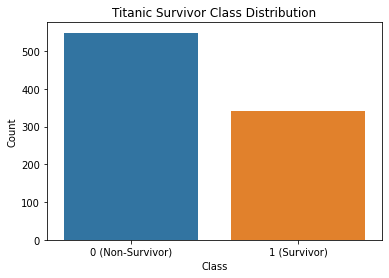

In [17]:
fig, ax = plt.subplots()
sns.countplot(x='Survived', data=df, ax=ax)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Titanic Survivor Class Distribution')
ax.set_xticklabels(['0 (Non-Survivor)', '1 (Survivor)'])

Plot distribution for each feature in Titanic dataset

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

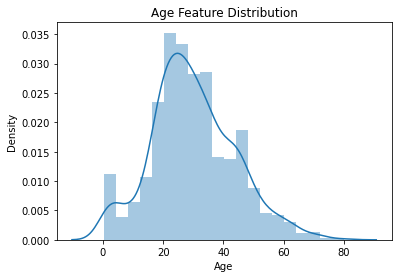

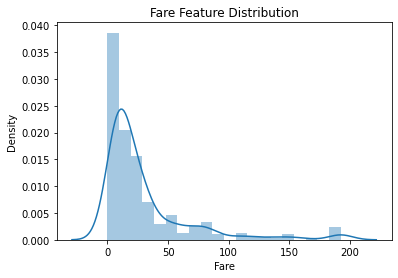

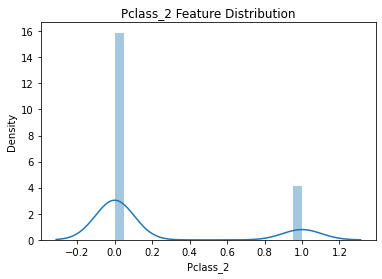

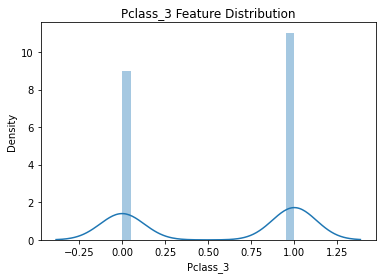

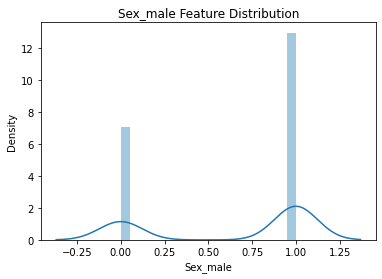

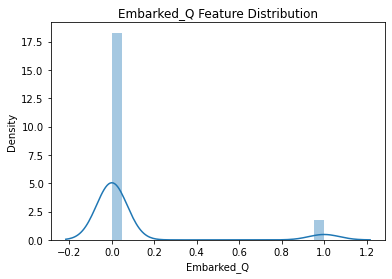

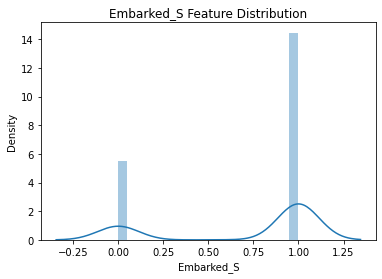

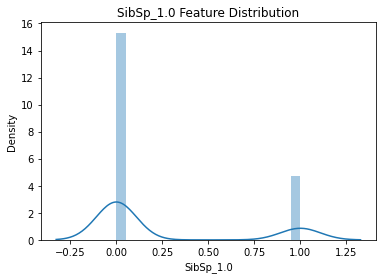

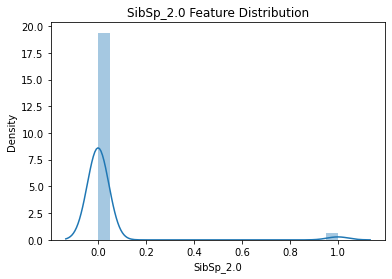

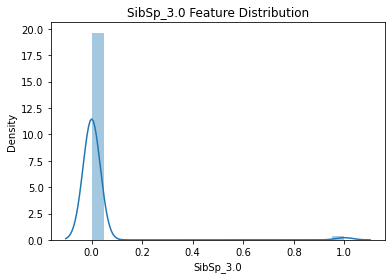

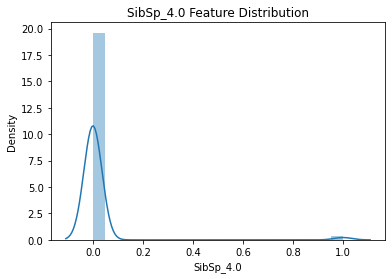

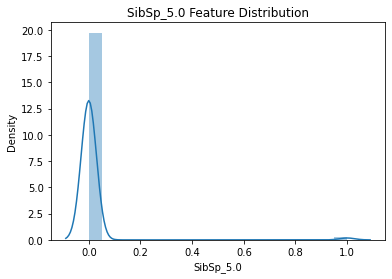

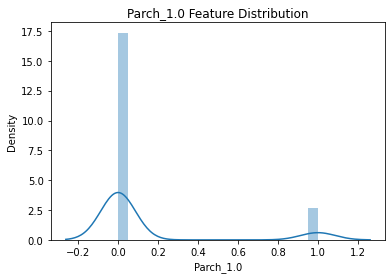

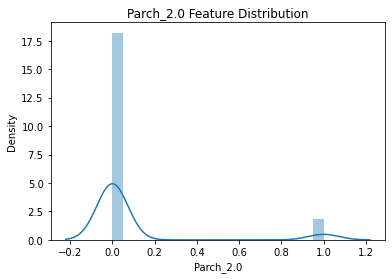

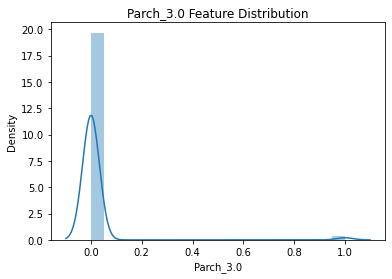

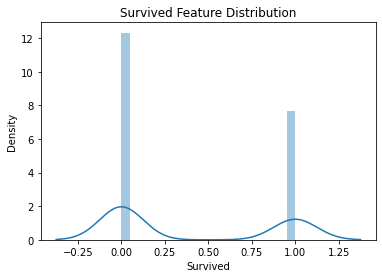

In [18]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=20)
    ax.set_title(f'{feat} Feature Distribution')

Calculate VIF to confirm that there are no correlated features

In [19]:
vif_x = df.drop(columns=['Survived'])
vif_y = df['Survived']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.25, random_state=121)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,34.0
1,Pclass_3,4.0
2,Fare,2.6
3,Pclass_2,2.6
4,Parch_2.0,1.6
5,Age,1.6
6,Embarked_Q,1.5
7,Embarked_S,1.5
8,Parch_1.0,1.3
9,SibSp_5.0,1.3


# Model Data

Create x and y variables

In [20]:
x = df.drop(columns=['Survived'])
y = df['Survived']

Perform train test split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=121)

Standard scale data

In [22]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)

Build and evaluate dummy classifier

In [23]:
dc = DummyClassifier(strategy='stratified', random_state=73)
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier: 
Train f1 Score:  0.33954451345755693
Train Accuracy Score: 0.5224550898203593
Test f1 Score:  0.28205128205128205
Test Accuracy Score: 0.4977578475336323


Gridsearch Logistic Regression Model

In [24]:
lr_gs_dict = {'C': [x/100 for x in range(1,501)]}
lr_gs_model = LogisticRegression(random_state=204)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_estimator_)
print(lr_gs.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
LogisticRegression(C=2.61, random_state=204)
0.8068566939737403


Build and evaluate top performing gridsearch logistic regression model

In [24]:
lr = LogisticRegression(C=2.61, random_state=204)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression: 
Train f1 Score:  0.7484407484407485
Train Accuracy Score: 0.8188622754491018
Test f1 Score:  0.7597765363128491
Test Accuracy Score: 0.8071748878923767


Gridsearch SVC model

In [29]:
svc_gs_dict = {'C': [x/1000 for x in range(620, 721)],
               'gamma': [x/1000 for x in range(10, 111)]}
svc_gs_model = SVC(random_state=491)
svc_gs = GridSearchCV(svc_gs_model, svc_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
svc_gs.fit(x_train, y_train)

print(svc_gs.best_estimator_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 10201 candidates, totalling 51005 fits
SVC(C=0.668, gamma=0.064, random_state=491)
0.8188418808214566


Fit and evaluate top performing SVC model

In [25]:
svc = SVC(C=0.668, gamma=0.064, random_state=491, probability=True)
svc.fit(x_train, y_train)
y_train_pred_svc = svc.predict(x_train)
y_test_pred_svc = svc.predict(x_test)
print('SVC: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_svc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_svc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_svc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_svc))

SVC: 
Train f1 Score:  0.7747368421052632
Train Accuracy Score: 0.8398203592814372
Test f1 Score:  0.7251461988304092
Test Accuracy Score: 0.7892376681614349


Gridsearch adaboost model

In [35]:
ab_gs_dict = {'learning_rate': [x/100 for x in range(100, 201)],
             'n_estimators': [x*10 for x in range(5, 11)]}
ab_gs_model = AdaBoostClassifier(random_state=19)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)

print(ab_gs.best_estimator_)
print(ab_gs.best_score_)

Fitting 5 folds for each of 606 candidates, totalling 3030 fits
AdaBoostClassifier(learning_rate=1.64, n_estimators=60, random_state=19)
0.8263606778139378


Fit and evaluate top performing adaboost model

In [26]:
ab = AdaBoostClassifier(learning_rate=1.64, n_estimators=60, random_state=19)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_ab))

Adaboost: 
Train f1 Score:  0.8
Train Accuracy Score: 0.8502994011976048
Test f1 Score:  0.711864406779661
Test Accuracy Score: 0.7713004484304933


Gridsearch random forest model

In [50]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [x/16 for x in range(1, 17)],
              'max_leaf_nodes': [x for x in range(35, 50)],
              'max_samples': [x/100 for x in range(35, 50)]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
RandomForestClassifier(criterion='entropy', max_features=1.0, max_leaf_nodes=42,
                       max_samples=0.43, n_jobs=-1, random_state=712)
0.8487599596004938


In [95]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [x/16 for x in range(8, 17)],
              'max_samples': [x/1000 for x in range(960, 981)],
              'min_impurity_decrease': [x/10000 for x in range(55, 75)]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 7560 candidates, totalling 37800 fits
RandomForestClassifier(criterion='entropy', max_features=0.875,
                       max_samples=0.972, min_impurity_decrease=0.0067,
                       n_jobs=-1, random_state=712)
0.8488272921108742


Fit and evaluate top performing random forest model

In [45]:
rf = RandomForestClassifier(criterion='entropy', max_features=1, max_leaf_nodes=42, max_samples=0.43, n_jobs=-1,
                       random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.8595387840670858
Train Accuracy Score: 0.8997005988023952
Test f1 Score:  0.7439024390243902
Test Accuracy Score: 0.8116591928251121


In [76]:
rf = RandomForestClassifier(criterion='entropy', max_features=0.875, max_samples=0.97,
                       min_impurity_decrease=0.0064, n_jobs=-1, random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.8364389233954451
Train Accuracy Score: 0.8817365269461078
Test f1 Score:  0.736196319018405
Test Accuracy Score: 0.8071748878923767


Gridsearch xgboost model

In [40]:
xgb_gs_dict = {'colsample_bynode': [x/16 for x in range(6, 13)],
               'gamma': [.21, .215, .22, .225, .23],
               'learning_rate': [.4, .405, .41, .415, .42],
               'reg_lambda': [1.93, 1.94, 1.95, 1.96, 1.97],
               'subsample': [.4, .405, .41, .415, .42]}
xgb_gs_model = XGBClassifier(random_state=137, n_jobs=-1)
xgb_gs = GridSearchCV(xgb_gs_model, xgb_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
xgb_gs.fit(x_train, y_train)

print(xgb_gs.best_estimator_)
print(xgb_gs.best_score_)

Fitting 5 folds for each of 4375 candidates, totalling 21875 fits
[21:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.5625, colsample_bytree=1,
              enable_categorical=False, gamma=0.22, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.41, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=137, reg_alpha=0, reg_lambda=1.95,
              scale_pos_weight=1, subsample=0.41, tree_method='exact',
              v

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fit and evaluate top performing xgboost model

In [43]:
xgb = XGBClassifier(colsample_bynode=0.5625, gamma=0.22, learning_rate=0.41,reg_lambda=1.95, subsample=0.41,
                    random_state=137, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)
print('XGBoost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_xgb))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_xgb))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_xgb))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_xgb))

[21:49:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost: 
Train f1 Score:  0.9068825910931174
Train Accuracy Score: 0.9311377245508982
Test f1 Score:  0.7011494252873562
Test Accuracy Score: 0.7668161434977578


C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fit and evaluate voting classifier

In [59]:
vc = VotingClassifier([('lr', lr), ('rf', rf)], voting='soft', weights=[1, 7])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Voting Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_vc))

Voting Classifier: 
Train f1 Score:  0.8347457627118645
Train Accuracy Score: 0.8832335329341318
Test f1 Score:  0.7530864197530865
Test Accuracy Score: 0.820627802690583
